# RGI08 (Scandinavia)

F. Maussion & S. Galos

Same as RGI6. Details:
- in Northern Norway there is a new inventory by Liss but we decided to not use it for consistency (not super strong opinions)
- at the border there were a few outlines to merge in GLIMS to match the RGI

In [ ]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, find_duplicates
import os

## Files and storage paths

In [ ]:
# Region of interest
reg = 8

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '07_rgi60_Scandinavia.zip')

### Load the input data

In [ ]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [ ]:
sdf, _ = submission_summary(shp)
sdf

- 611 is RGI6 but for Norway only (many outlines stop at the border...)
- 362 is RGI6 in Sweden (middle Lappland)
- 363 is RGI6 in Sweden (northern Lappland)
- 364 is RGI6 in Sweden (southern Lappland)
- 365 is RGI6 in Sweden (Jämtland)
- 733 to 742: new regions for parts of northern norway. We decide to use 738 in replacement for 611 where possible
- 758: merging of a few outlines at the border - it replaced the old submissions that were replaced

In [ ]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

For now, we stick to reproducing RGI6:

In [ ]:
# do that based on relevant submission IDs (611, 362, 363, 364, 365, 758)
rgi7 = (shp.loc[shp['subm_id'].isin([611, 362, 363, 364, 365, 758])]).copy()
rgi7['is_rgi6'] = True

In [ ]:
# Size filter?
print(len(rgi7))
rgi7 = size_filter(rgi7)
len(rgi7)

### Uncomment below if you want to update with the new inventory

OK now take care of the new inventory. We need to make a geometry around it for selection: 

In [ ]:
# new = (shp.loc[shp['subm_id'].isin([738])]).copy()
# new['is_rgi6'] = False

# # Size filter?
# print(len(new))
# new = size_filter(new)
# len(new)

Make a box aroun the region (I checked in GIS, it's ok to do so):

In [ ]:
# import shapely.geometry as shpg
# hull = gpd.GeoDataFrame({'geometry':[shpg.MultiPolygon(new.geometry.values).convex_hull]})
# hull.crs = new.crs

# f, ax = plt.subplots(figsize=(8, 12))
# hull.plot(ax=ax, edgecolor='k');
# new.plot(ax=ax, facecolor='C3', edgecolor='k');

In [ ]:
# # Remove all old rgi outlines
# rp = rgi7.representative_point()
# rp = rp.to_frame('geometry')
# rp['orig_index'] = rgi7.index

# # Find non overlying polygons
# difference = gpd.overlay(rp, hull, how='difference')

# # Create new rgi
# rgi7 = rgi7.loc[difference['orig_index']].copy()
# assert rgi7.anlys_id.isin([355145]).sum() == 0  # This is the only geometry down there which might have not fit in the polygon

In [ ]:
# # Merge
# rgi7 = pd.concat([rgi7, new])

### Some sanity checks 

In [ ]:
sdf, df_class = submission_summary(rgi7)
df_class

In [ ]:
dupes = find_duplicates(rgi7)

In [ ]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

In [ ]:
plot_map(rgi7, reg, loc='upper left', linewidth=2)

In [ ]:
plot_map(rgi7, reg, loc='upper left', linewidth=2, is_rgi6=True)

In [ ]:
plot_date_hist(rgi7, reg)

### Text for github

In [ ]:
fgh = sdf.T
fgh

In [ ]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

## Write out and tar 

In [ ]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

## Consistency check with RGI6 

In [ ]:
# load reference data
from utils import open_zip_shapefile
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [ ]:
len(rgi7), len(rgi6)

In [ ]:
# Select only the relevant parts for the rest of the tests:
# rp = rgi7.representative_point()
# rp = rp.to_frame('geometry')
# rp['orig_index'] = rgi7.index
# difference = gpd.overlay(rp, hull, how='difference')
# rgi7 = rgi7.loc[difference['orig_index']].copy()

# rp = rgi6.representative_point()
# rp = rp.to_frame('geometry')
# rp['orig_index'] = rgi6.index
# difference = gpd.overlay(rp, hull, how='difference')
# rgi6 = rgi6.loc[difference['orig_index']].copy()

Test the areas:

In [ ]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [ ]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['area'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['area'].sum() - rgi7['area'].sum()) * 1e-6)

### Problems below are corrected now

So, the difference is small... BUT there are issues at the Norway-Sweden border. Screenshots:

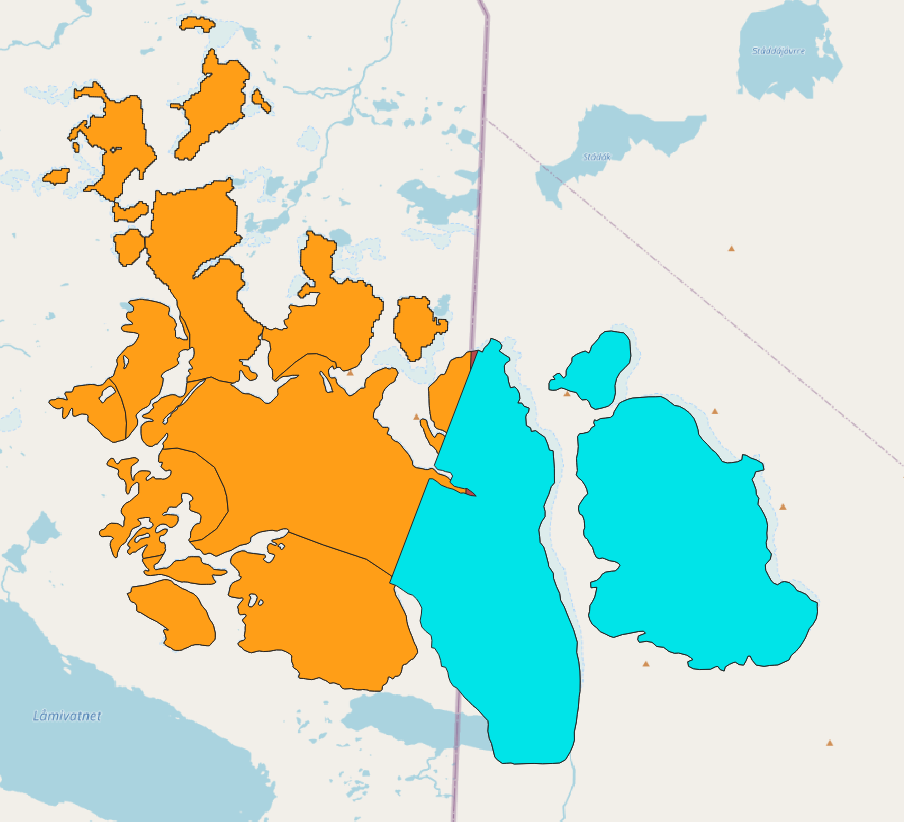

Note that RGI6 has some corrections:

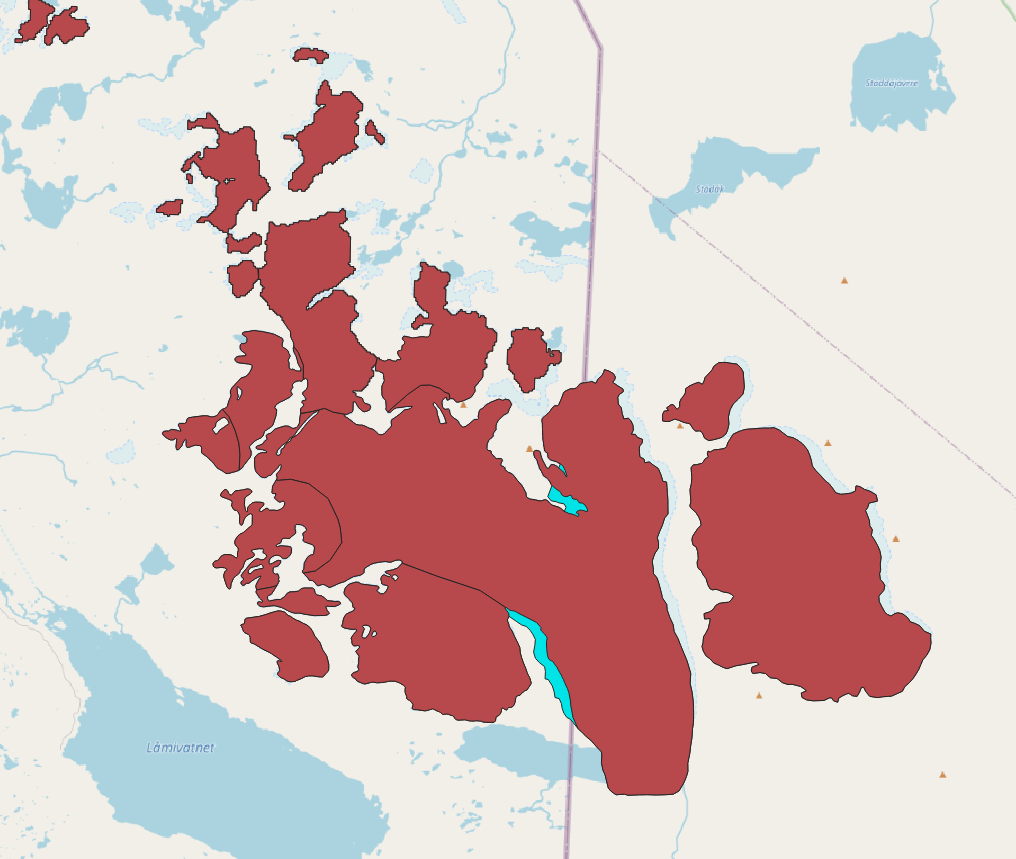

This would be a way to address the problem, but it needs ingested in GLIMS (https://trello.com/c/gprXN5RU):

In [ ]:
# Write the output so that we can eventually retire the outlines in GLIMS
output_dir = mkdir(os.path.join(data_dir, 'l3_problem_glaciers'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_problem_glaciers_tar'))

dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

for ids in [[354438, 55064], [354713, 55092]]:
    tomerge = rgi7.loc[rgi7.anlys_id.isin(ids)]
    tomerge.plot(facecolor='none', edgecolor='k');
    new = tomerge.dissolve()
    new.plot(facecolor='none', edgecolor='k');
    new['area'] = new.to_crs({'proj':'cea'}).area 
    
    # Store
    tomerge.to_file(dd + f'{new.glac_id[0]}_toreplace.shp')
    new.to_file(dd + f'{new.glac_id[0]}_merged.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))